### Visualizing the distribution of the observations

### Load the required libraries

In [29]:
import pandas as pd
import numpy as np
import sklearn as sk3
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['/Users/prahalarora/Desktop/lib/numpy_pack.py','/Users/prahalarora/Desktop/lib/spark_PCA.py','/Users/prahalarora/Desktop/lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12452
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[E0 58 B0 58 28 5...|1997.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[50 57 F0 56 A0 5...|1998.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[28 58 80 58 50 5...|1999.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [34]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USR0000CBRI')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USR0000CBRI'
14 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(14, 365)

In [71]:
# Rough Work
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USR0000CBRI')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
a = df1.collect()
print a[0]['vector'].decode('window')
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT vector FROM weather
	WHERE measurement='TMAX' and station='USR0000CBRI'
14 rows
 S@RáW0UαUáVPWáW(XáW(XPW XáW@VÇTαUαU@VαTαU≡VXXáWPWαU≡V░X░XXX╕YΦYáWl\l\l\l\l\l\l\l\l\l\ÿ\ÿ\ÿ\ÿ\l\l\l\ ~l\l\l\l\PW(XPW░X XPW(XáV`YÇX X(XáW≡V(XáW8Y╕YpZ╕YÇXáVÉU0UαTXXαXXY╕Y╕YÿZ@Z`Y [á[H[ΦYÇXáW≡V`YZ╕YZ XÇX0UÇXαUXXXX(X╕Yá[\x[`Y`YXX(XXXÉYαX(X@Z8Y(XÉY8Y░XXX8YXXáWXX0U╕Y╕YΦYá[\8YáW8YÿZÉYÉY`YΦYl\ÿ\@\l\@Z(XpZ╕YZpZ≡Z╚Z╕Y@ZΦY≡Z╚ZÇXXX`YαY╚Z\ä]ñ]ⁿ](^@\@Z\`Y╕YΦYpZpZä\,\á[ÿ\X\ÿZÿZZx[ä\É]ⁿ]▄\≡Zl\pZ@Z╚ZÿZH[ [x[x]ñ]▄\l\x]ⁿ]x]4]▄\H[≡Zä\\`]▄\ÿZl\`]É]ñ] [╚Zx[╚\É]░\ \`]ÿ\ [ÿZX\ [╚Zä\ä\╚\á[x[╚Zá[ ]ñ]`]▄\Z [l\l\╨[X\\pZ╚\É]╝]▄\▄\╚Z╨[╚Z≡Z╨[╚Z@Z\l\░\░]@\l\ \ \╨[@\ä\@Zx[á[ÿ\`Y [,\ä\ÿ\l\╨[pZH[x[@Z,\X\╨[╚Z╕Y XαX8YpZ [╕Y@Zx[x[αX╚Z [ \@\á[╕Y≡Z╚Z╕Y@ZΦY@Z╚Z [≡Z`YpZ@Z [ÿZαXαXÇY8YÉY╕YαU(X XXXPWÇX X(XáVáS(XÇX0U@RÉU0UáVáWÇX≡V XÇX8Y


(14, 365)

### Script for plotting yearly plots

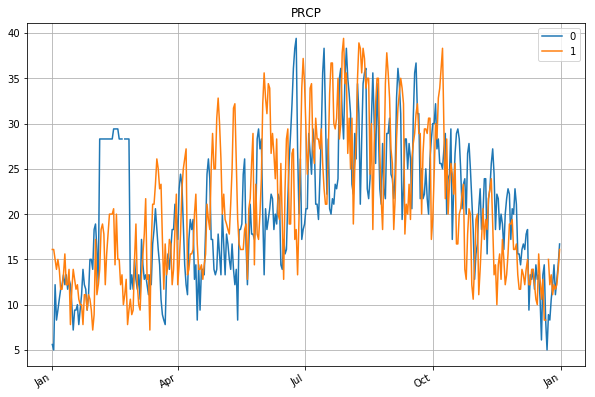

In [18]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [35]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/prahalarora/anaconda/envs/Ana2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


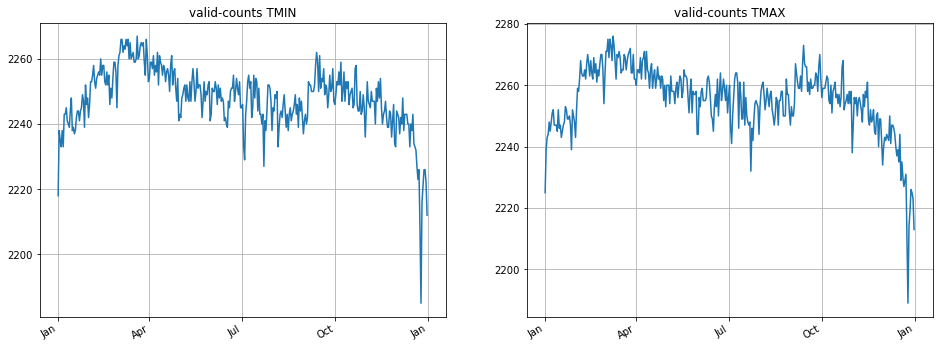

In [36]:
plot_pair(['TMIN','TMAX'],plot_valid)

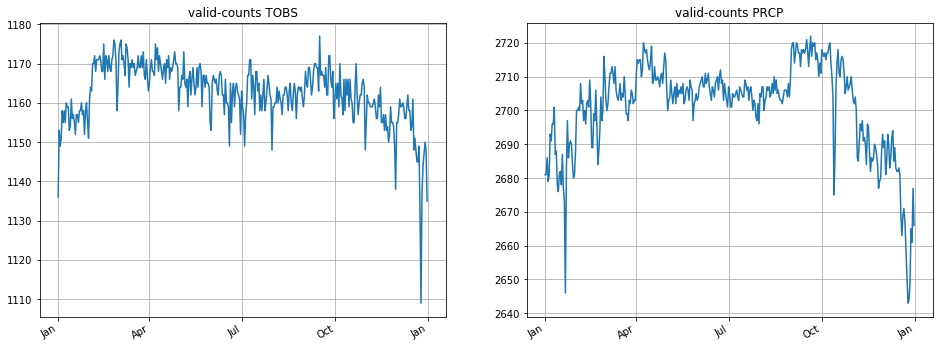

In [37]:
plot_pair(['TOBS','PRCP'],plot_valid)

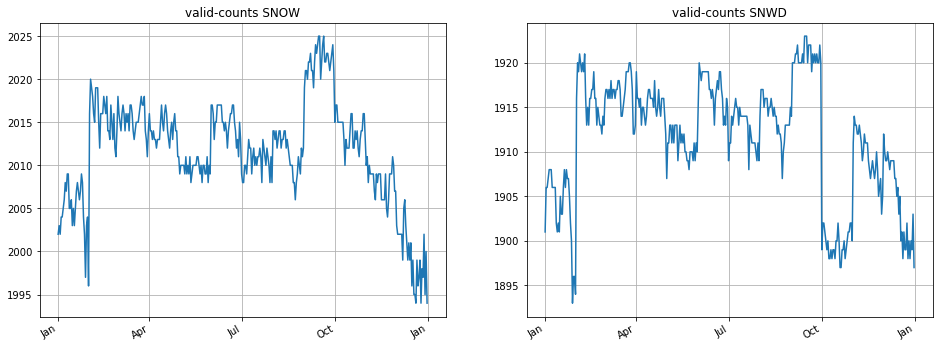

In [38]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [39]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

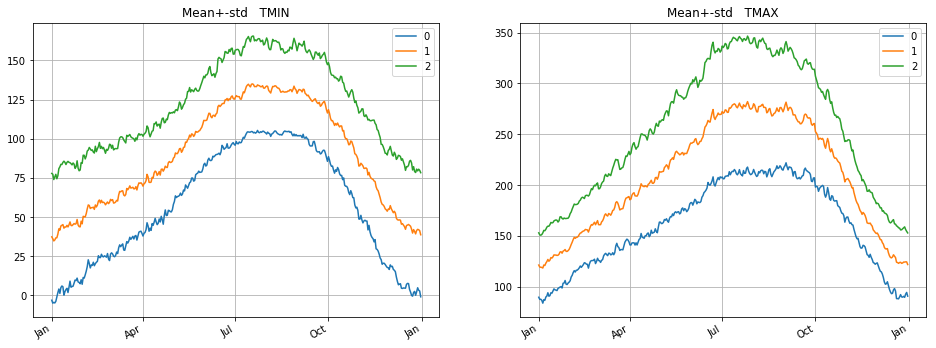

In [43]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

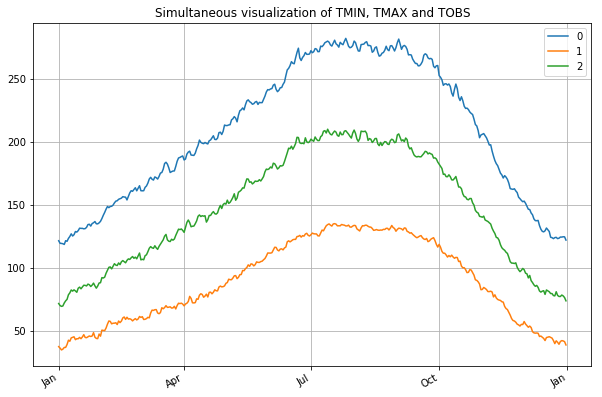

In [74]:
tmax = STAT['TMAX']['Mean']
tmin = STAT['TMIN']['Mean']
t_avg = STAT['TOBS']['Mean']

graphs=np.vstack([tmax,tmin,t_avg]).transpose()
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(graphs,fig,ax,title='Simultaneous visualization of TMIN, TMAX and TOBS')

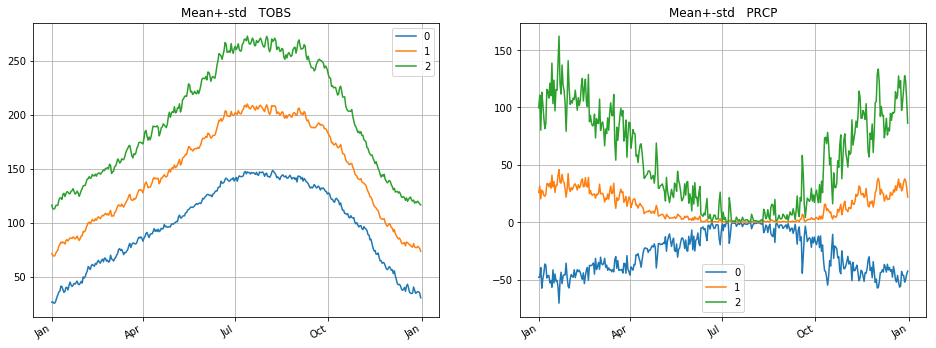

In [46]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

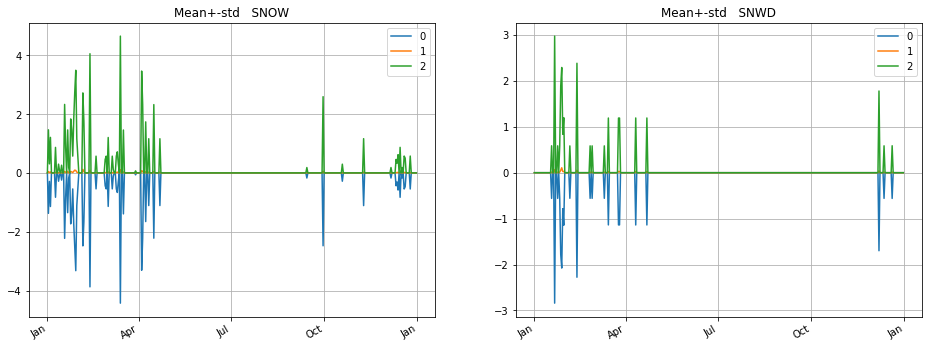

In [47]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [48]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

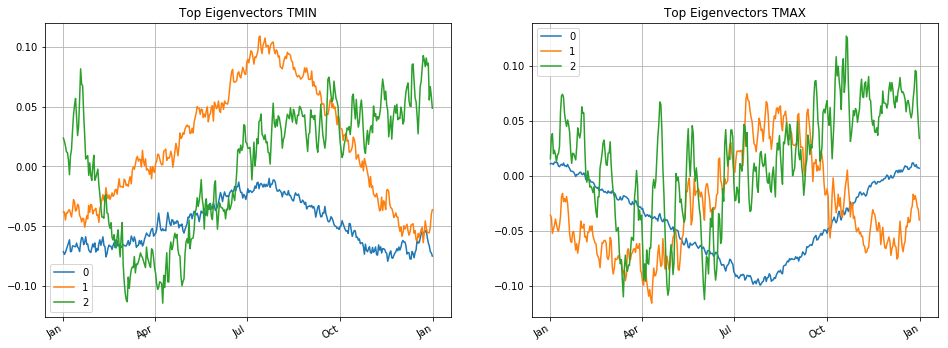

In [49]:
plot_pair(['TMIN','TMAX'],plot_eigen)

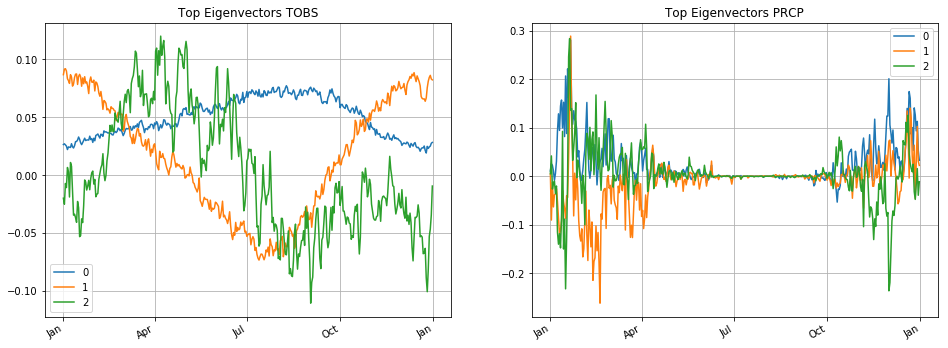

In [50]:
plot_pair(['TOBS','PRCP'],plot_eigen)

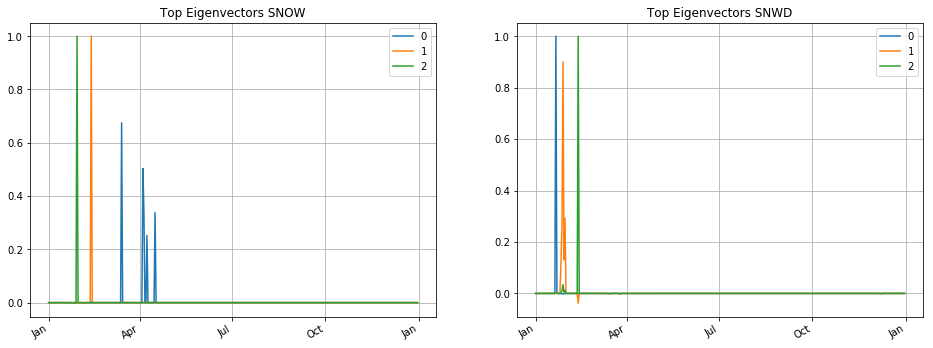

In [51]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [75]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

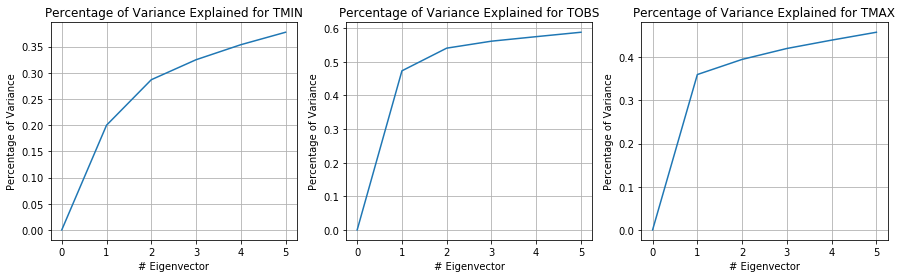

In [76]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

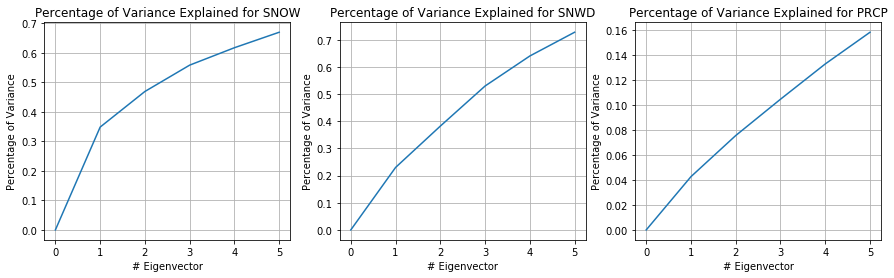

In [77]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()